
-----------

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

# Stereo Calibration

In [1]:
%matplotlib inline 

In [8]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pickle
import json
import time
from camera_calibrate import CameraCalibration, Markers
from glob import glob

In [10]:
def get_images(path, gray=False):
    """
    Given a path, it reads all images. This uses glob to grab file names
    and excepts wild cards *
    Ex. getImages('./images/*.jpg')
    """
    imgs_l = []
    imgs_r = []
    files = glob(path)

    print("Found {} images at {}".format(len(tuple(files)), path))

    for i, f in enumerate(files):
        img = cv2.imread(f)
        if img is None:
            print('>> Could not read: {}'.format(f))
            continue
        h, w = img.shape[:2]

        if gray:
            if len(img.shape) > 2:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            l = img[:, :w//2]
            r = img[:, w//2:]
        else:
            l = img[:, :w//2, :]
            r = img[:, w//2:, :]

        imgs_l.append(l)
        imgs_r.append(r)
    return imgs_l, imgs_r

In [11]:
class StereoCalibration(object):
    def __init__(self):
        self.camera_model = None
        self.save_cal_imgs = None

    def save(self, filename, handler=pickle):
        if self.camera_model is None:
            print("no camera model to save")
            return
        with open(filename, 'wb') as f:
            handler.dump(self.camera_model, f)

    def stereo_calibrate(self, imgs_l, imgs_r, marker_type, marker_size, marker_scale=1):
        """
        This will save the found markers for camera_2 (right) only in
        self.save_cal_imgs array
        """
        cc = CameraCalibration()
        rms1, M1, d1, r1, t1, objpoints, imgpoints_l = cc.calibrate(
            imgs_l, marker_type, marker_size, marker_scale)
        rms2, M2, d2, r2, t2, objpoints, imgpoints_r = cc.calibrate(
            imgs_r, marker_type, marker_size, marker_scale)
        self.save_cal_imgs = cc.save_cal_imgs

        flags = 0
        flags |= cv2.CALIB_FIX_INTRINSIC
        # flags |= cv2.CALIB_FIX_PRINCIPAL_POINT
        flags |= cv2.CALIB_USE_INTRINSIC_GUESS
        flags |= cv2.CALIB_FIX_FOCAL_LENGTH
        # flags |= cv2.CALIB_FIX_ASPECT_RATIO
        flags |= cv2.CALIB_ZERO_TANGENT_DIST
        # flags |= cv2.CALIB_RATIONAL_MODEL
        # flags |= cv2.CALIB_SAME_FOCAL_LENGTH
        # flags |= cv2.CALIB_FIX_K3
        # flags |= cv2.CALIB_FIX_K4
        # flags |= cv2.CALIB_FIX_K5

        stereocalib_criteria = (cv2.TERM_CRITERIA_MAX_ITER +
                                cv2.TERM_CRITERIA_EPS, 100, 1e-5)

        ret, M1, d1, M2, d2, R, T, E, F = cv2.stereoCalibrate(
            objpoints,
            imgpoints_l,
            imgpoints_r,
            M1, d1,
            M2, d2,
            imgs_l[0].shape[:2],
            criteria=stereocalib_criteria,
            flags=flags)

        print('-'*50)
        print('Image: {}x{}'.format(*imgs_l[0].shape[:2]))
        print('{}: {}'.format(marker_type, marker_size))
        print('Intrinsic Camera Parameters')
        print('-'*50)
        print(' [Camera 1]')
        # print('  cameraMatrix_1', M1)
        print('  f(x,y): {:.1f} {:.1f} px'.format(M1[0,0], M1[1,1]))
        print('  principlePoint(x,y): {:.1f} {:.1f} px'.format(M1[0,2], M1[1,2]))
        print('  distCoeffs', d1[0])
        print(' [Camera 2]')
        # print('  cameraMatrix_2', M2)
        print('  f(x,y): {:.1f} {:.1f} px'.format(M2[0,0], M2[1,1]))
        print('  principlePoint(x,y): {:.1f} {:.1f} px'.format(M2[0,2], M2[1,2]))
        print('  distCoeffs', d2[0])
        print('-'*50)
        print('Extrinsic Camera Parameters')
        print('-'*50)
        print('  R', R)
        print('  T[meter]', T)
        print('  E', E)
        print('  F', F)

        # for i in range(len(r1)):
        #     print("--- pose[", i+1, "] ---")
        #     ext1, _ = cv2.Rodrigues(r1[i])
        #     ext2, _ = cv2.Rodrigues(r2[i])
        #     print('Ext1', ext1)
        #     print('Ext2', ext2)

        # print('')
        self.camera_model = {
            'date': time.strftime("%a, %d %b %Y %H:%M:%S", time.localtime()),
            'markerType': marker_type,
            'markerSize': marker_size,
            'imageSize': imgs_l[0].shape[:2],
            'cameraMatrix1': M1,
            'cameraMatrix2': M2,
            'distCoeffs1': d1,
            'distCoeffs2': d2,
            # 'rvecs1': r1,
            # 'rvecs2': r2,
            'R': R,
            'T': T,
            'E': E,
            'F': F
        }

        return ret

Found 16 images at checkerboard-imgs/*.png


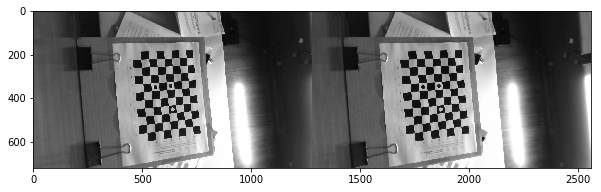

In [19]:
path = 'checkerboard-imgs/*.png'
marker = Markers.checkerboard
dims = (7,10)
scale = 0.02  # 2 cm on each side
fname = 'cb_camera_model.pickle'
imgs_l, imgs_r = get_images(path, gray=True)

plt.figure(figsize=(10,8))
plt.imshow(np.hstack((imgs_l[4], imgs_r[4])), cmap='gray');

In [13]:
sc = StereoCalibration()
ok = sc.stereo_calibrate(imgs_l, imgs_r, marker, dims, marker_scale=scale)

Images: 16 @ (720, 1280)
Markers.checkerboard (7, 10)
----------------------------------------
[0] + found 70.0 of 70 corners
[1] + found 70.0 of 70 corners
[2] + found 70.0 of 70 corners
[3] + found 70.0 of 70 corners
[4] + found 70.0 of 70 corners
[5] + found 70.0 of 70 corners
[6] + found 70.0 of 70 corners
[7] + found 70.0 of 70 corners
[8] + found 70.0 of 70 corners
[9] + found 70.0 of 70 corners
[10] + found 70.0 of 70 corners
[11] + found 70.0 of 70 corners
[12] + found 70.0 of 70 corners
[13] + found 70.0 of 70 corners
[14] + found 70.0 of 70 corners
[15] + found 70.0 of 70 corners
RMS error: 0.5223794653295155
----------------------------------------
Images: 16 @ (720, 1280)
Markers.checkerboard (7, 10)
----------------------------------------
[0] + found 70.0 of 70 corners
[1] + found 70.0 of 70 corners
[2] + found 70.0 of 70 corners
[3] + found 70.0 of 70 corners
[4] + found 70.0 of 70 corners
[5] + found 70.0 of 70 corners
[6] + found 70.0 of 70 corners
[7] + found 70.0 of 

---


# Stereo Vision

![](images/stereo_frames.png)

Now we won't go into stereo vision too much, it is really complicated to get it to work right all the time, but we'll show a simple example. The same idea we had before for the camera model can be expanded to 2 or more cameras.

With a normal, single camera we cannot determine depth. However, if we have a second camera, we can now calculate depth. Looking at the left image plane, point x lines along a line in 3D space we cannot measure with a single camera. However, with a second camera, that line cuts across it's image plane to form a line. This line in the right image plane is called an **epiline** which means, to find the point x on the right image, search along this epiline. Think of it this way, to find the matching point in other image, you need not search the whole image, just search along the epiline which will provide better performance and accuracy.  This is called **Epipolar Constraint**. Similarly all points will have its corresponding epilines in the other image. 

![](stereo/epipolar.jpg)

Now, generally, the 2 camera frames are located side-by-side. we also need both camera's to be calibrated, so straight lines are straight (don't want our epilines to be curved or messed up). We also need to understand the distance between each camera, called the baseline. Unfortunately, the calibration, orientation of the cameras (think mounting of the cameras to something), and distance between them has to be very accurate. Otherwise the math to calculate disparity (or reconstruct where things are in 3D space) will not work correctly.

We need a couple of things to make this work.

- **Essential Matrix (E):** contains the information about translation and rotation between the 2 cameras in global coordinates.
- **Fundamental Matrix (F):** contains the same information as E, but also contains intrinsics of both cameras so that we can relate the two cameras in pixel coordinates.

Now, as long as both cameras are calibrated (meaning they produce rectified images) and we normalize the points we are trying to match by the focal length, then, F = E. In simple words, Fundamental Matrix F, maps a point in one image to a line (epiline) in the other image. This is calculated from matching points from both the images. A minimum of 8 such points are required to find the fundamental matrix (while using [8-point algorithm](https://en.wikipedia.org/wiki/Eight-point_algorithm)). More points are preferred and use RANSAC to get a more robust result.

![](stereo/essential_matrix.jpg)

Now the diagram above shows the image planes rotated in for effect, but typically they are not. Frames that are perfectly aligned with the world and each other have an ideal matrix like: 

![](images/stereo_matrix.png)

Realistically though, there will be some rotation between them and misalignment such that there are more terms.

Now that we have our cameras all calibrated and we understand the alignment between them. The basic idea of calculating the disparity is:

![](images/stereo_depth.jpg)

which leads to $disparity = x - x' = \frac{Bf}{Z}$ where B is the baseline (shown as T above, sorry) and Z is the distance from the camera. Note, disparity is **not** the position in the world **unless** the world's origin is at the camera location (which is highly unlikely).

Also, algorithms that try to find stereo matches and calculate the disparity need calibrated cameras so that straight lines appear straight in the image. A common technique is to find key points in one image and then look in the second image alone the same row for the same key point. If the camera image is distorted, then key points won't appear where they are expected and the algorithm won't be able to calculate disparity.